# Experimenting with xarray-simlab

Following tutorial material in [xarray-simlab docs](https://xarray-simlab.readthedocs.io/en/latest/create_model.html) to try to set up a simple EBM driven by xarray-simlab.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xsimlab as xs

## Getting started: advection example from the docs

First just make sure the example in the docs works as advertised:

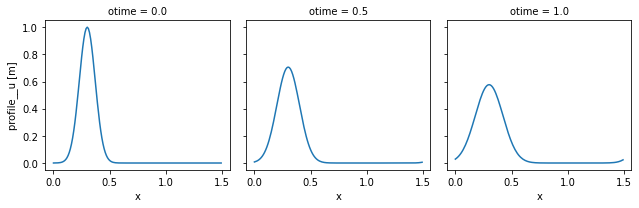

In [2]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)
    length = xs.variable(description="total length", static=True)
    x = xs.index(dims="x")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)
        
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}
    )

    def run_step(self):
        self._delta_u = sum((v for v in self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u
        
@xs.process
class AdvectionLax:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "x"], description="velocity")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_advected = xs.variable(dims="x", intent="out", groups="u_vars")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = self.v / (2 * self.grid_spacing)

        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        u_1 = 0.5 * (u_right + u_left) - factor * dt * (u_right - u_left)

        self.u_advected = u_1 - self.u
        
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    scale = xs.variable(description="scale of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

advect_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "advect": AdvectionLax,
    }
)

in_ds = xs.create_setup(
        model=advect_model,
    clocks={
    'time': np.linspace(0., 1., 101),
    'otime': [0, 0.5, 1]
    },
    master_clock='time',
    input_vars={
    'grid': {'length': 1.5, 'spacing': 0.01},
    'init': {'loc': 0.3, 'scale': 0.1},
    'advect__v': 0.
    },
    output_vars={
    'profile__u': 'otime'
    }
    )

out_ds = in_ds.xsimlab.run(model=advect_model)

out_ds.profile__u.plot(col='otime', figsize=(9, 3));

## A simple diffusion model

Try to repeat the simple diffusion example at https://brian-rose.github.io/ClimateLaboratoryBook/courseware/numerical-diffusion.html
with the FTCS scheme.

The equation to be solved is

$$ \frac{\partial u}{\partial t} = K \frac{\partial^2 u}{\partial x^2} $$

with no-flux boundary conditions $\frac{\partial u}{\partial x} = 0$ at $x=0,1$.

In [3]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    #num_points = xs.variable(description="number of points", static=True)
    length = xs.variable(description="total length", static=True)
    spacing = xs.variable(description="grid spacing")
    x = xs.index(dims="x")
    xstag = xs.index(dims="xstag")

    def initialize(self):
        #self.spacing = 1./self.num_points
        self.xstag = np.arange(0., self.length+self.spacing, self.spacing)
        self.x = self.xstag[:-1] + self.spacing/2
        
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}
    )

    def run_step(self):
        self._delta_u = sum((v for v in self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u
        
@xs.process
class DiffusionFTCS:
    """Diffusion using FTCS scheme

    """
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    x = xs.foreign(UniformGrid1D, "x")
    xstag = xs.foreign(UniformGrid1D, "xstag")
    u = xs.foreign(ProfileU, "u")
    u_diffused = xs.variable(dims="x", intent="out", groups="u_vars")
    K = xs.variable(description="diffusion coefficient", intent="in")
    flux = xs.on_demand(description="diffusive flux", dims="xstag")
    #flux = xs.variable(description="diffusive flux", dims="xstag", intent="out")
    
    @flux.compute
    def compute_flux(self):
        #  Flux on staggered grid, zeroes at both end (no flux)
        F = np.zeros(len(self.u)+1)
        #  Take the finite difference
        F[1:-1] = np.diff(self.u)/self.grid_spacing
        #  flux is DOWN gradient, proportional to K
        return -self.K*F
        
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        #  compute flux and take its convergence
        #self.flux = self.compute_flux()
        dudt = -np.diff(self.flux) / self.grid_spacing
        self.u_diffused = dt * dudt
        
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    std = xs.variable(description="standard deviation of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / (2*self.std**2) * (self.x-self.loc) ** 2) / np.sqrt(2*np.pi*self.std**2)

In [4]:
diff_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "diffusion": DiffusionFTCS,
    }
)

In [5]:
diff_model

<xsimlab.Model (4 processes, 5 inputs)>
grid
    length      [in] total length
    spacing     [in] grid spacing
init
    loc         [in] location of initial pulse
    std         [in] standard deviation of initial pulse
diffusion
    K           [in] diffusion coefficient
profile

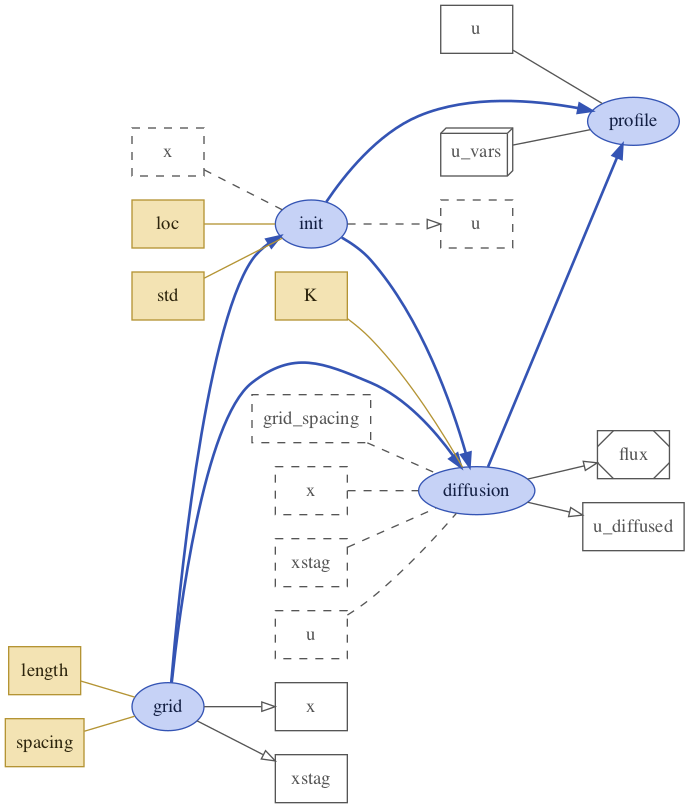

In [6]:
diff_model.visualize(show_inputs=True, show_variables=True)

In [7]:
num_steps = 11
deltat = 0.125

in_ds = xs.create_setup(
            model=diff_model,
            clocks={
               'time': np.linspace(0., num_steps*deltat, num_steps+1),
               'otime': np.linspace(0., num_steps*deltat, num_steps+1)
                   },
            master_clock='time',
            input_vars={
                'grid': {'length': 1.0, 'spacing': 0.05},
                'init': {'loc': 0.5, 'std': 0.08},
                'diffusion__K': 0.01,
                       },
            output_vars={
               'profile__u': 'otime',
               'diffusion__flux': 'otime',
                        }
            )

In [8]:
out_ds = in_ds.xsimlab.run(model=diff_model)
out_ds

<xarray.Dataset>
Dimensions:          (otime: 12, xstag: 21, x: 20, time: 12)
Coordinates:
  * otime            (otime) float64 0.0 0.125 0.25 0.375 ... 1.125 1.25 1.375
  * time             (time) float64 0.0 0.125 0.25 0.375 ... 1.125 1.25 1.375
  * x                (x) float64 0.025 0.075 0.125 0.175 ... 0.875 0.925 0.975
  * xstag            (xstag) float64 0.0 0.05 0.1 0.15 0.2 ... 0.85 0.9 0.95 1.0
Data variables:
    diffusion__K     float64 0.01
    diffusion__flux  (otime, xstag) float64 -0.0 -7.199e-07 ... 0.01138 -0.0
    grid__length     float64 1.0
    grid__spacing    float64 0.05
    init__loc        float64 0.5
    init__std        float64 0.08
    profile__u       (otime, x) float64 1.103e-07 3.71e-06 ... 0.1643 0.1074

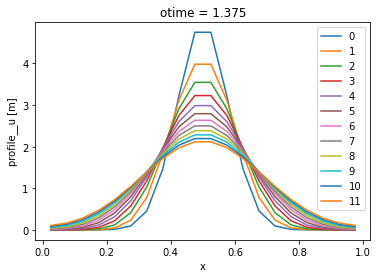

In [9]:
fig, ax = plt.subplots()
for i,otime in enumerate(out_ds.otime):
    out_ds.profile__u.sel(otime=otime).plot(ax=ax, label=i)
ax.legend()

And if we now double the spatial resolution, we create numerical instability:

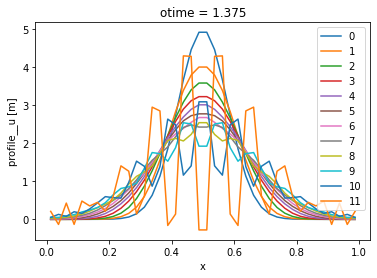

In [10]:
in_ds = xs.create_setup(
            model=diff_model,
            clocks={
               'time': np.linspace(0., num_steps*deltat, num_steps+1),
               'otime': np.linspace(0., num_steps*deltat, num_steps+1)
                   },
            master_clock='time',
            input_vars={
                'grid': {'length': 1.0, 'spacing': 0.05/2},
                'init': {'loc': 0.5, 'std': 0.08},
                'diffusion__K': 0.01,
                       },
            output_vars={
               'profile__u': 'otime'
                        }
            )
out_ds = in_ds.xsimlab.run(model=diff_model)

fig, ax = plt.subplots()
for i,otime in enumerate(out_ds.otime):
    out_ds.profile__u.sel(otime=otime).plot(ax=ax, label=i)
ax.legend()

This reproduces the FTCS results in the Climate Laboratory chapter.

## Use the climlab implicit solver instead

In [11]:
from climlab.dynamics import adv_diff_numerics

In [12]:
#  use class inheritance here to avoid redefining the stuff that doesn't change
@xs.process
class DiffusionImplicit(DiffusionFTCS):
    """Diffusion using fully implicit scheme

    """        
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        use_banded_solver = False
        Karray = np.ones_like(self.xstag) * self.K
        Uarray = 0*Karray
        W = np.ones_like(self.u)
        Wb = np.ones_like(Karray)
        self._advdiffTriDiag = adv_diff_numerics.advdiff_tridiag(X=self.x,
                                                                 Xb=self.xstag, 
                                                                 K=Karray, 
                                                                 U=Uarray, 
                                                                 W=W, 
                                                                 Wb=Wb,
                                                                 use_banded_solver=use_banded_solver)
        newu = adv_diff_numerics.implicit_step_forward(self.u,
                                                self._advdiffTriDiag,
                                                0.,
                                                dt,
                                                use_banded_solver=use_banded_solver)
        
        self.u_diffused = newu - self.u

In [13]:
implicitdiff_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "diffusion": DiffusionImplicit,
    }
)

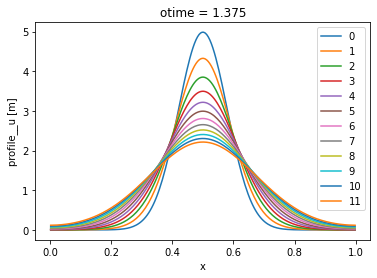

In [14]:
num_steps = 11
deltat = 0.125

in_ds = xs.create_setup(
            model=implicitdiff_model,
            clocks={
               'time': np.linspace(0., num_steps*deltat, num_steps+1),
               'otime': np.linspace(0., num_steps*deltat, num_steps+1)
                   },
            master_clock='time',
            input_vars={
                'grid': {'length': 1.0, 'spacing': 0.05/10},
                'init': {'loc': 0.5, 'std': 0.08},
                'diffusion__K': 0.01,
                       },
            output_vars={
               'profile__u': 'otime',
               'diffusion__flux': 'otime',
                        }
            )

out_ds = in_ds.xsimlab.run(model=implicitdiff_model)

fig, ax = plt.subplots()
for i,otime in enumerate(out_ds.otime):
    out_ds.profile__u.sel(otime=otime).plot(ax=ax, label=i)
ax.legend()

The implicit method is numerically stable for any timestep so we can get very high spatial resolution.

## A more climlab-like way to package all this

In [15]:
from climlab import constants as const
from climlab.utils.legendre import P2

@xs.process
class Domain:
    """Create a 1-dimensional, equally spaced latitude grid from pole to pole"""
    num_lat = xs.variable(description="number of latitude points", static=True)
    lat = xs.index(dims="lat")
    lat_bounds = xs.index(dims="lat_bounds")
    spacing = xs.on_demand(description="grid spacing", dims="lat")
        
    @spacing.compute
    def compute_spacing(self):
        return 180./self.num_lat

    def initialize(self):
        self.lat_bounds = np.linspace(-90., 90., self.num_lat+1)
        self.lat = self.lat_bounds[:-1] + self.spacing/2     
        
@xs.process
class State:
    """Compute the evolution of the profile of quantity `u`."""

    delta_Ts_vars = xs.group("delta_Ts")
    Ts = xs.variable(dims="lat", intent="inout", description="Surface temperature", attrs={"units": "K"})
    lat = xs.foreign(Domain, "lat")
    
    def run_step(self):
        self._delta_Ts = sum((v for v in self.delta_Ts_vars))

    def finalize_step(self):
        self.Ts += self._delta_Ts
        
@xs.process
class MeridionalDiffusion:
    """Diffusion along latitude axis using implicit time scheme

    """
    grid_spacing = xs.foreign(Domain, "spacing")
    lat = xs.foreign(Domain, "lat")
    lat_bounds = xs.foreign(Domain, "lat_bounds")
    Ts = xs.foreign(State, "Ts")
    delta_Ts_diffused = xs.variable(dims="lat", intent="out", groups="delta_Ts")
    K = xs.variable(description="diffusion coefficient", intent="in")
    flux = xs.on_demand(description="diffusive flux", dims="lat_bounds")
    
    @flux.compute
    def compute_flux(self):
        #  Flux on staggered grid, zeroes at both end (no flux)
        F = np.zeros_like(self.lat_bounds)
        #  Take the finite difference
        F[1:-1] = np.diff(self.Ts)/self.grid_spacing
        #  flux is DOWN gradient, proportional to K
        return -self.K*F
        
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        phi_stag = np.deg2rad(self.lat_bounds)
        phi = np.deg2rad(self.lat)
        use_banded_solver = False
        Karray = np.ones_like(self.lat_bounds) * self.K
        Uarray = 0*Karray
        W = np.ones_like(self.Ts)
        Wb = np.ones_like(Karray)
        self._advdiffTriDiag = adv_diff_numerics.advdiff_tridiag(X=phi*const.a,
                                                                 Xb=phi_stag*const.a, 
                                                                 K=Karray, 
                                                                 U=Uarray, 
                                                                 W=np.cos(phi), 
                                                                 Wb=np.cos(phi_stag),
                                                                 use_banded_solver=use_banded_solver)
        newTs = adv_diff_numerics.implicit_step_forward(self.Ts,
                                                self._advdiffTriDiag,
                                                0.,
                                                dt,
                                                use_banded_solver=use_banded_solver)
        self.delta_Ts_diffused = newTs - self.Ts        
        
@xs.process
class InitTsP2:
    """Initialize `Ts` profile using a 2nd order Legendre polynomial"""

    T0 = xs.variable(description="Global mean temperature", static=True)
    T2 = xs.variable(description="2nd Legendre coefficient", static=True)
    lat = xs.foreign(Domain, "lat")
    Ts = xs.foreign(State, "Ts", intent="out")

    def initialize(self):
        self.Ts = self.T0 + self.T2*P2(np.sin(np.deg2rad(self.lat)))

In [16]:
climdiff_model = xs.Model(
    {
        "domain": Domain,
        "state": State,
        "init": InitTsP2,
        "diffusion": MeridionalDiffusion,
    }
)

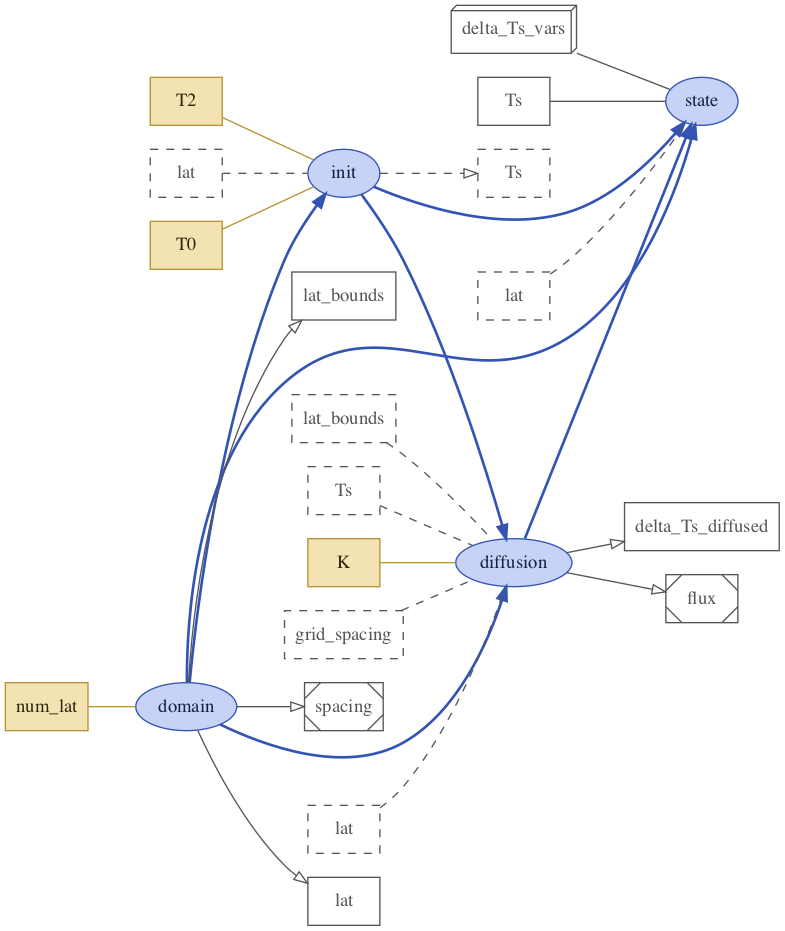

In [17]:
climdiff_model.visualize(show_inputs=True, show_variables=True)

In [18]:
climdiff_model

<xsimlab.Model (4 processes, 4 inputs)>
domain
    num_lat     [in] number of latitude points
init
    T0          [in] Global mean temperature
    T2          [in] 2nd Legendre coefficient
diffusion
    K           [in] diffusion coefficient
state

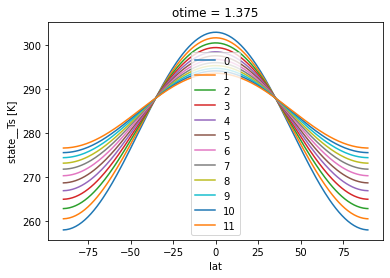

In [19]:
num_steps = 11
deltat = 0.125

in_ds = xs.create_setup(
            model=climdiff_model,
            clocks={
               'time': np.linspace(0., num_steps*deltat, num_steps+1),
               'otime': np.linspace(0., num_steps*deltat, num_steps+1)
                   },
            master_clock='time',
            input_vars={
                'domain': {'num_lat': 200,},
                'init': {'T0': 288, 'T2': -30},
                'diffusion': {'K': 5E12,},
            },
            output_vars={
               'state__Ts': 'otime',
               'diffusion__flux': 'otime',
                        }
            )

out_ds = in_ds.xsimlab.run(model=climdiff_model)

fig, ax = plt.subplots()
for i,otime in enumerate(out_ds.otime):
    out_ds.state__Ts.sel(otime=otime).plot(ax=ax, label=i)
ax.legend()

## A simple EBM with multiple proceses

The equation is

$$ C \frac{\partial T}{\partial t} = \frac{S_0}{4} \left(1 + s_2 P_2(\sin\theta) \right) - \left(A+BT\right) + \frac{D}{\cos\theta} \frac{\partial}{\partial \theta} \left( \cos\theta \frac{\partial T}{\partial \theta}  \right) $$

with $D$ in the same units as $B$

In [20]:
@xs.process
class Domain:
    """Create a 1-dimensional, equally spaced latitude grid from pole to pole"""
    num_lat = xs.variable(description="number of latitude points", static=True)
    water_depth = xs.variable(description="depth of water in the slab", static=True)
    lat = xs.index(dims="lat")
    lat_bounds = xs.index(dims="lat_bounds")
    spacing = xs.on_demand(description="grid spacing", dims="lat")
    heat_capacity = xs.on_demand(description="heat capacity per unit surface area in J/m2/K", dims="lat")
        
    @spacing.compute
    def compute_spacing(self):
        return 180./self.num_lat
    
    @heat_capacity.compute
    def compute_heat_capacity(self):
        return self.water_depth * const.rho_w * const.cw

    def initialize(self):
        self.lat_bounds = np.linspace(-90., 90., self.num_lat+1)
        self.lat = self.lat_bounds[:-1] + self.spacing/2

@xs.process
class State:
    """Compute the evolution of the profile of quantity `T_s`."""
    lat = xs.foreign(Domain, "lat")
    delta_Ts_vars = xs.group("delta_Ts")
    Ts_tendency_vars = xs.group("Ts_tendency")
    Ts = xs.variable(dims="lat", intent="inout", description="Surface temperature", attrs={"units": "K"})
    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self._delta_Ts = ( sum((tend for tend in self.Ts_tendency_vars))*dt + 
            sum((v for v in self.delta_Ts_vars)) )

    def finalize_step(self):
        self.Ts += self._delta_Ts
        
@xs.process
class AplusBT:
    lat = xs.foreign(Domain, "lat")
    A = xs.variable(description="Outgoing radiation at 0 degrees C", intent="in")
    B = xs.variable(description="Temperature dependence of outgoing radiation", intent="in")
    olr = xs.on_demand(description="Outgoing Longwave Radiation", dims="lat")
    Ts = xs.foreign(State, "Ts")
    tendency = xs.variable(description="Time tendency due to OLR", intent="out", dims="lat", groups="Ts_tendency")
    heat_capacity = xs.foreign(Domain, "heat_capacity")
    
    @olr.compute
    def compute_olr(self):
        return self.A + self.B*self.Ts
    
    def run_step(self):
        self.tendency = -self.olr / self.heat_capacity
        
@xs.process
class Insolation:
    solar_constant = xs.variable(description="The solar constant in W/m2", intent="in")
    lat = xs.foreign(Domain, "lat")
    s2 = xs.variable(intent="in")
    insolation = xs.on_demand(dims="lat")
    
    @insolation.compute
    def compute_insolation(self):
        return self.solar_constant/4 * (1 + self.s2*P2(np.sin(np.deg2rad(self.lat))) )
    
@xs.process
class ASR:
    lat = xs.foreign(Domain, "lat")
    insolation = xs.foreign(Insolation, "insolation")
    albedo = xs.variable(description="Top of atmosphere albedo", intent="in")
    asr = xs.on_demand(description="Absorbed shortwave radiation", dims="lat")
    tendency = xs.variable(description="Time tendency due to ASR", dims="lat", intent="out", groups="Ts_tendency")
    heat_capacity = xs.foreign(Domain, "heat_capacity")

    @asr.compute
    def compute_asr(self):
        return self.insolation*(1-self.albedo)
    
    def run_step(self):
        self.tendency = self.asr / self.heat_capacity

@xs.process
class MeridionalHeatDiffusion:
    """Diffusion of heat along latitude axis using implicit time scheme

    """
    grid_spacing = xs.foreign(Domain, "spacing")
    lat = xs.foreign(Domain, "lat")
    lat_bounds = xs.foreign(Domain, "lat_bounds")
    heat_capacity = xs.foreign(Domain, "heat_capacity")
    Ts = xs.foreign(State, "Ts")
    delta_Ts_diffused = xs.variable(dims="lat", intent="out", groups="delta_Ts")
    D = xs.variable(description="heat diffusion coefficient", intent="in")
    K = xs.on_demand(description="diffusion coefficient")
    flux = xs.on_demand(description="diffusive flux", dims="lat_bounds")
    
    @K.compute
    def compute_K(self):
        return self.D / self.heat_capacity * const.a**2
    
    @flux.compute
    def compute_flux(self):
        #  Flux on staggered grid, zeroes at both end (no flux)
        F = np.zeros_like(self.lat_bounds)
        #  Take the finite difference
        F[1:-1] = np.diff(self.Ts)/self.grid_spacing
        #  flux is DOWN gradient, proportional to D
        return -self.K*F
        
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        phi_stag = np.deg2rad(self.lat_bounds)
        phi = np.deg2rad(self.lat)
        use_banded_solver = False
        Karray = np.ones_like(self.lat_bounds) * self.K
        Uarray = 0*Karray
        W = np.ones_like(self.Ts)
        Wb = np.ones_like(Karray)
        self._advdiffTriDiag = adv_diff_numerics.advdiff_tridiag(X=phi*const.a,
                                                                 Xb=phi_stag*const.a, 
                                                                 K=Karray, 
                                                                 U=Uarray, 
                                                                 W=np.cos(phi), 
                                                                 Wb=np.cos(phi_stag),
                                                                 use_banded_solver=use_banded_solver)
        newTs = adv_diff_numerics.implicit_step_forward(self.Ts,
                                                self._advdiffTriDiag,
                                                0.,
                                                dt,
                                                use_banded_solver=use_banded_solver)
        self.delta_Ts_diffused = newTs - self.Ts        
        
@xs.process
class InitTsP2:
    """Initialize `Ts` profile using a 2nd order Legendre polynomial"""

    T0 = xs.variable(description="Global mean temperature", static=True)
    T2 = xs.variable(description="2nd Legendre coefficient", static=True)
    lat = xs.foreign(Domain, "lat")
    Ts = xs.foreign(State, "Ts", intent="out")

    def initialize(self):
        self.Ts = self.T0 + self.T2*P2(np.sin(np.deg2rad(self.lat)))

In [21]:
ebm_model = xs.Model(
    {
        "domain": Domain,
        "state": State,
        "init": InitTsP2,
        "insolation": Insolation,
        "ASR": ASR,
        "OLR": AplusBT,
        "diffusion": MeridionalHeatDiffusion,
    }
)

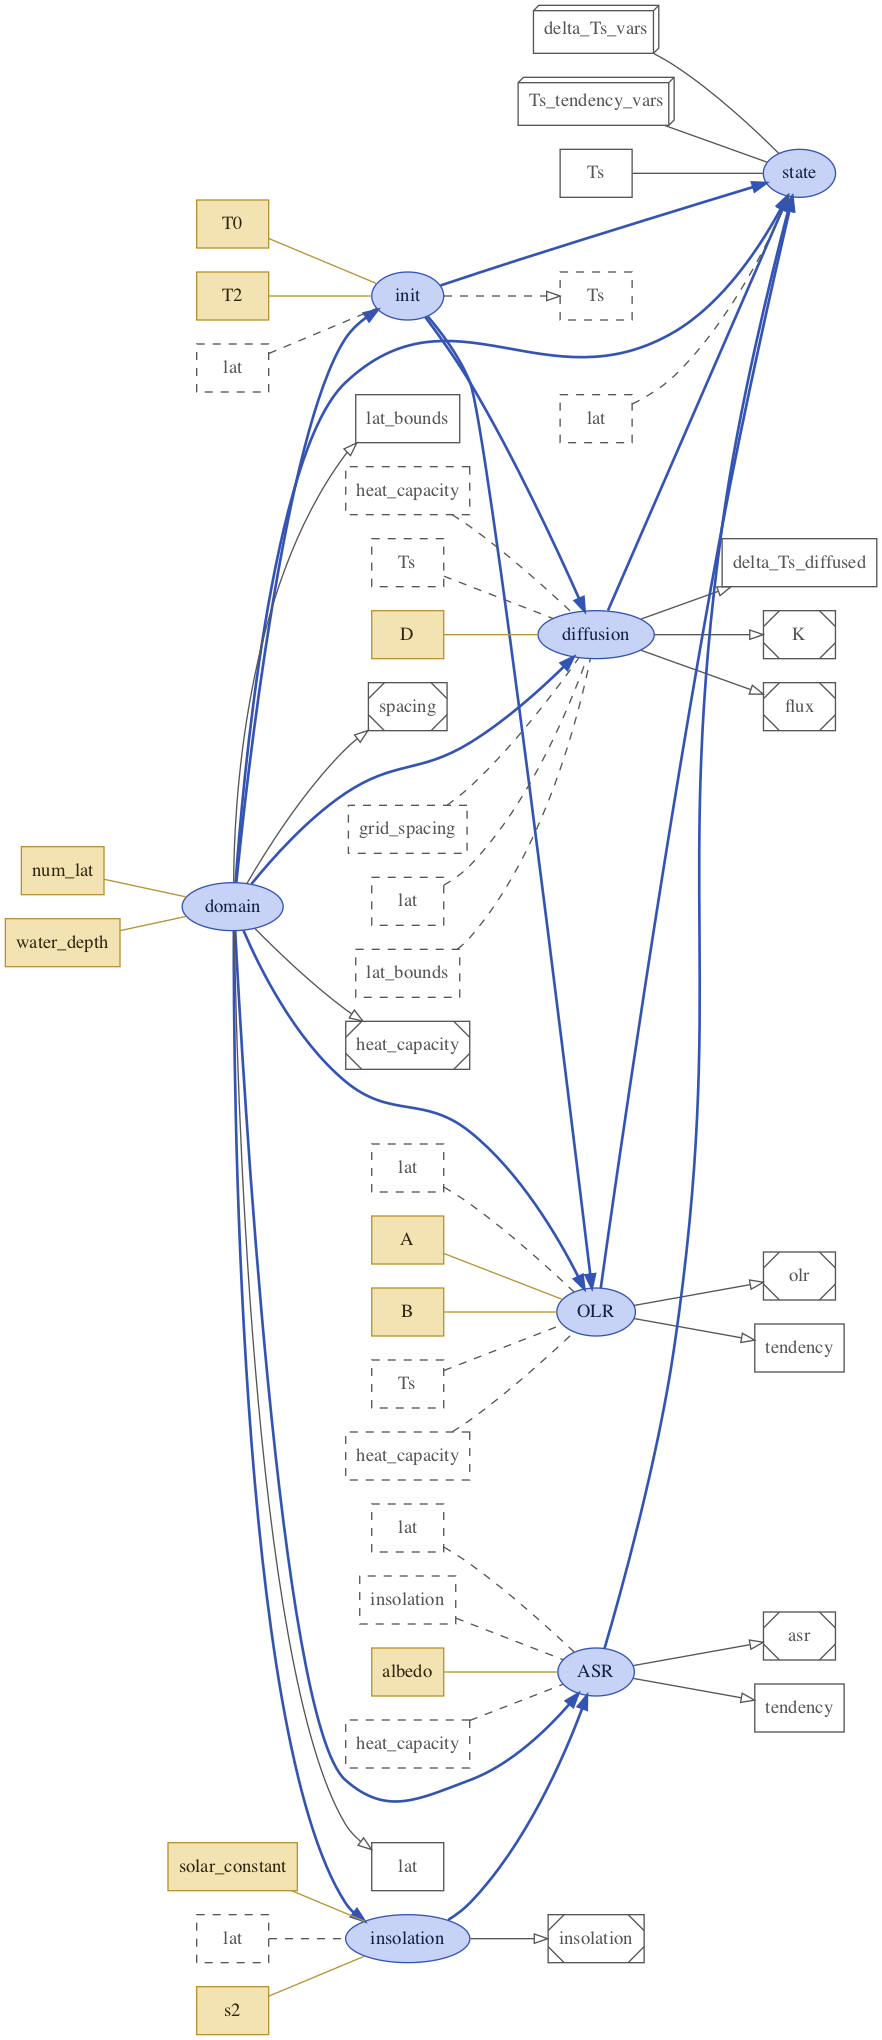

In [22]:
ebm_model.visualize(show_inputs=True, show_variables=True)

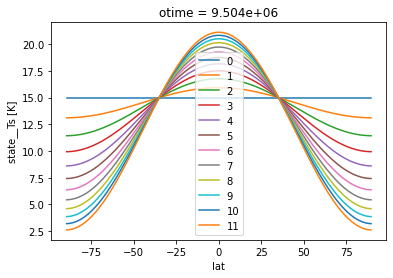

In [23]:
num_steps = 11
deltat = const.seconds_per_day*10

in_ds = xs.create_setup(
            model=ebm_model,
            clocks={
               'time': np.linspace(0., num_steps*deltat, num_steps+1),
               'otime': np.linspace(0., num_steps*deltat, num_steps+1)
                   },
            master_clock='time',
            input_vars={
                'domain': {'num_lat': 200, 'water_depth': 10,},
                'init': {'T0': 15., 'T2': 0},
                'diffusion': {'D': 0.6,},
                'insolation': {'solar_constant': 1370., 's2': -0.38,},
                'ASR': {'albedo': 0.3},
                'OLR': {'A': 210, 'B': 2.},
            },
            output_vars={
               'state__Ts': 'otime',
               'diffusion__flux': 'otime',
               'ASR__asr': 'otime',
               'OLR__olr': 'otime',
               'insolation__insolation': 'otime',
                        }
            )

out_ds = in_ds.xsimlab.run(model=ebm_model)

fig, ax = plt.subplots()
for i,otime in enumerate(out_ds.otime):
    out_ds.state__Ts.sel(otime=otime).plot(ax=ax, label=i)
ax.legend()

In [24]:
out_ds

<xarray.Dataset>
Dimensions:                     (otime: 12, lat: 200, lat_bounds: 201, time: 12)
Coordinates:
  * lat                         (lat) float64 -89.55 -88.65 ... 88.65 89.55
  * lat_bounds                  (lat_bounds) float64 -90.0 -89.1 ... 89.1 90.0
  * otime                       (otime) float64 0.0 8.64e+05 ... 9.504e+06
  * time                        (time) float64 0.0 8.64e+05 ... 9.504e+06
Data variables: (12/15)
    ASR__albedo                 float64 0.3
    ASR__asr                    (otime, lat) float64 148.7 148.7 ... 148.7 148.7
    OLR__A                      int64 210
    OLR__B                      float64 2.0
    OLR__olr                    (otime, lat) float64 240.0 240.0 ... 215.3 215.2
    diffusion__D                float64 0.6
    ...                          ...
    init__T0                    float64 15.0
    init__T2                    int64 0
    insolation__insolation      (otime, lat) float64 212.4 212.5 ... 212.5 212.4
    insolation__s2              float64 -0.38
    insolation__solar_constant  float64 1.37e+03
    state__Ts                   (otime, lat) float64 15.0 15.0 ... 2.629 2.62

In [25]:
out_ds.ASR__asr.sel(otime=0)

<xarray.DataArray 'ASR__asr' (lat: 200)>
array([148.65342955, 148.72085346, 148.85563473, 149.05764036,
       149.326671  , 149.66246113, 150.06467938, 150.5329288 ,
       151.06674729, 151.66560804, 152.32892004, 153.05602868,
       153.84621639, 154.69870336, 155.61264828, 156.5871492 ,
       157.62124441, 158.71391337, 159.86407776, 161.0706025 ,
       162.33229689, 163.6479158 , 165.01616088, 166.43568182,
       167.90507773, 169.4228985 , 170.98764622, 172.59777667,
       174.25170085, 175.94778653, 177.68435988, 179.45970712,
       181.2720762 , 183.11967851, 185.0006907 , 186.91325645,
       188.85548827, 190.82546942, 192.82125577, 194.84087771,
       196.88234213, 198.94363434, 201.02272009, 203.11754759,
       205.22604949, 207.34614495, 209.47574169, 211.61273806,
       213.75502511, 215.90048864, 218.04701136, 220.19247489,
       222.33476194, 224.47175831, 226.60135505, 228.72145051,
       230.82995241, 232.92477991, 235.00386566, 237.06515787,
       239.10662229, 241.12624423, 243.12203058, 245.09201173,
       247.03424355, 248.9468093 , 250.82782149, 252.6754238 ,
       254.48779288, 256.26314012, 257.99971347, 259.69579915,
       261.34972333, 262.95985378, 264.5246015 , 266.04242227,
       267.51181818, 268.93133912, 270.2995842 , 271.61520311,
...
       271.61520311, 270.2995842 , 268.93133912, 267.51181818,
       266.04242227, 264.5246015 , 262.95985378, 261.34972333,
       259.69579915, 257.99971347, 256.26314012, 254.48779288,
       252.6754238 , 250.82782149, 248.9468093 , 247.03424355,
       245.09201173, 243.12203058, 241.12624423, 239.10662229,
       237.06515787, 235.00386566, 232.92477991, 230.82995241,
       228.72145051, 226.60135505, 224.47175831, 222.33476194,
       220.19247489, 218.04701136, 215.90048864, 213.75502511,
       211.61273806, 209.47574169, 207.34614495, 205.22604949,
       203.11754759, 201.02272009, 198.94363434, 196.88234213,
       194.84087771, 192.82125577, 190.82546942, 188.85548827,
       186.91325645, 185.0006907 , 183.11967851, 181.2720762 ,
       179.45970712, 177.68435988, 175.94778653, 174.25170085,
       172.59777667, 170.98764622, 169.4228985 , 167.90507773,
       166.43568182, 165.01616088, 163.6479158 , 162.33229689,
       161.0706025 , 159.86407776, 158.71391337, 157.62124441,
       156.5871492 , 155.61264828, 154.69870336, 153.84621639,
       153.05602868, 152.32892004, 151.66560804, 151.06674729,
       150.5329288 , 150.06467938, 149.66246113, 149.326671  ,
       149.05764036, 148.85563473, 148.72085346, 148.65342955])
Coordinates:
  * lat      (lat) float64 -89.55 -88.65 -87.75 -86.85 ... 87.75 88.65 89.55
    otime    float64 0.0
Attributes:
    description:  Absorbed shortwave radiation

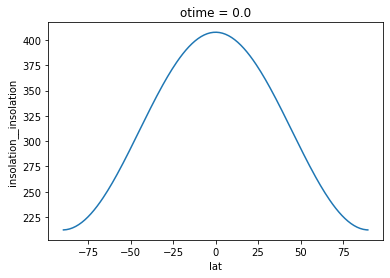

In [26]:
out_ds.insolation__insolation.sel(otime=0).plot()

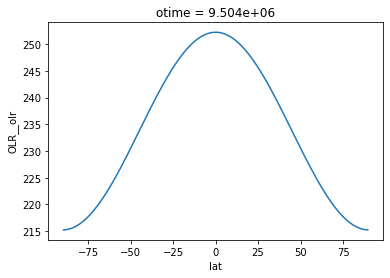

In [27]:
out_ds.OLR__olr.isel(otime=-1).plot()